In [1]:
import cplex
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ocp = cplex.Cplex()

In [3]:
# number of time points in the OCP
N = 25
dt = 3600.
time = np.arange(N)*dt

# prediction dictionary
pre = {'T_in_min': 20*np.ones(N),
       'T_em_max': 30*np.ones(N),
       'T_amb': 5 + 5*np.sin(2*np.pi*(time/24/3600-0.6)),
       'Q_flow_hp_max': 5000*np.ones(N),
       'Q_flow_sol': np.clip(2000*np.sin(2*np.pi*(time/24/3600-0.4)),0,10000),
       'p_el': np.clip( 0.18 + 0.10*np.sin(2*np.pi*(time/24/3600-0.0)),0,0.24 )}

# parameter dictionary
par = {'COP': 4,
       'C_in': 10e6,
       'C_em': 20e6,
       'UA_in_amb': 200,
       'UA_em_in': 1600}

In [4]:
ocp.variables.add(names = ['Q_flow_hp[{0}]'.format(i) for i in range(N)])
ocp.variables.add(names = ['T_in[{0}]'.format(i) for i in range(N)])
ocp.variables.add(names = ['T_em[{0}]'.format(i) for i in range(N)])

In [5]:
ocp.variables.set_lower_bounds( 'T_in[0]',pre['T_in_min'][0] )
# or
ocp.variables.set_lower_bounds( [('T_in[{0}]'.format(i)     ,pre['T_in_min'][i]) for i in range(N)] )
ocp.variables.set_upper_bounds( [('Q_flow_hp[{0}]'.format(i),pre['Q_flow_hp_max'][i]) for i in range(N)]
                               +[('T_em[{0}]'.format(i)     ,pre['T_em_max'][i]) for i in range(N)] )

In [6]:
ocp.objective.set_linear( 'Q_flow_hp[0]', par['COP']*pre['p_el'][0]/1000*dt/3600 )
# or
ocp.objective.set_linear( [('Q_flow_hp[{0}]'.format(i), par['COP']*pre['p_el'][i]/1000*dt/3600) for i in range(N)] )

In [7]:
ocp.objective.set_quadratic_coefficients( [('Q_flow_hp[%s]'%(i),'Q_flow_hp[%s]'%(i),0.01*par['COP']*pre['p_el'][i]/1000*dt/3600) for i in range(N)] )

In [8]:
cplex.SparsePair(ind = ['T_in[0]', 'T_in[1]'], val = [5.0, 6.5])

SparsePair(ind = ['T_in[0]', 'T_in[1]'], val = [5.0, 6.5])

In [9]:
# state constraints for T_in
# C_in/dt*(T_in[i+1]-T_in[i]) = UA_in_amb*(T_amb[i]-T_in[i]) + UA_em_in*(T_em[i]-T_in[i]) + Q_flow_sol[i]


ocp.linear_constraints.add( lin_expr = [ [['T_in[{0}]'.format(i)                           , 'T_in[{0}]'.format(i+1), 'T_em[{0}]'.format(i) ],
                                          [-par['C_in']/dt+par['UA_in_amb']+par['UA_em_in'], par['C_in']/dt         , -par['UA_em_in']      ]] for i in range(N-1)],
                            senses   = ['E' for i in range(N-1)],
                            rhs      = [par['UA_in_amb']*pre['T_amb'][i] + pre['Q_flow_sol'][i] for i in range(N-1)],
                            names    = ['state_T_in[{0}]'.format(i) for i in range(N-1)] )

# or
# state constraints for T_em
# C_em/dt*(T_em[i+1]-T_em[i]) = UA_em_in*(T_in[i]-T_em[i]) + Q_flow_hp[i]
ocp.linear_constraints.add( lin_expr = [ cplex.SparsePair( ind = ['T_em[{0}]'.format(i)          , 'T_em[{0}]'.format(i+1), 'T_in[{0}]'.format(i) , 'Q_flow_hp[{0}]'.format(i) ], 
                                                           val = [-par['C_em']/dt+par['UA_em_in'], par['C_em']/dt         , -par['UA_em_in']      , -1                         ]
                                                          ) for i in range(N-1)],
                            senses   = ['E' for i in range(N-1)],
                            rhs      = [0 for i in range(N-1)],
                            names    = ['state_T_em[{0}]'.format(i) for i in range(N-1)] )

In [10]:
# add initial values
ocp.linear_constraints.add(lin_expr = [[['T_in[0]'],
                                        [1        ]]],
                           senses   = 'E',
                           rhs      = [21],
                           names    = ['T_in_ini'])

ocp.linear_constraints.add(lin_expr = [[['T_em[0]'],
                                        [1        ]]],
                           senses   = 'E',
                           rhs      = [22],
                           names    = ['T_em_ini'])

In [11]:
ocp.linear_constraints.set_rhs( [('state_T_in[{0}]'.format(i),par['UA_in_amb']*pre['T_amb'][i] + pre['Q_flow_sol'][i]) for i in range(N-1)]  
                               +[('state_T_em[{0}]'.format(i),0) for i in range(N-1)] )

In [12]:
ocp.solve()

Tried aggregator 1 time.
QP Presolve eliminated 3 rows and 7 columns.
Aggregator did 4 substitutions.
Reduced QP has 43 rows, 64 columns, and 151 nonzeros.
Reduced QP objective Q matrix has 23 nonzeros.
Presolve time = 0.00 sec. (0.04 ticks)
Parallel mode: using up to 4 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 103
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.02 sec. (0.01 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 4
  Rows in Factor            = 43
  Integer space required    = 47
  Total non-zeros in factor = 386
  Total FP ops to factor    = 4222
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0  6.6832806e+005 -6.6726646e+005 1.02e+003 5.00e+002 1.19e+005
   1  4.9425743e+004 -4.9333080e+004 2.73e+002 1.33e+002 3.18e+004
   2  2.4922498e+004 -2.4288434e+004 1.75e+002 8.53e+001 2.04e+004
   3  3.4887657e+003 -2.5924761e+003 4.62e+001 2.26e+001 5.39e+003
   4

In [13]:
ocp.set_log_stream(None)
ocp.set_error_stream(None)
ocp.set_warning_stream(None)
ocp.set_results_stream(None)

In [14]:
sol = {}
sol['Q_flow_hp'] = np.array(ocp.solution.get_values(['Q_flow_hp[{0}]'.format(i) for i in range(N)]))
sol['T_in']      = np.array(ocp.solution.get_values(['T_in[{0}]'.format(i) for i in range(N)]))
sol['T_em']     = np.array(ocp.solution.get_values(['T_em[{0}]'.format(i) for i in range(N)]))
print(sol['T_in'])

[ 21.          20.63560269  20.66868564  20.65789637  20.58312991
  20.4745934   20.35731675  20.24211609  20.13887337  20.05675946  20.          20.
  20.          20.          20.03173812  20.11351282  20.22883109
  20.35779649  20.47934991  20.56951709  20.60026288  20.54368185
  20.38056326  20.1801851   20.        ]


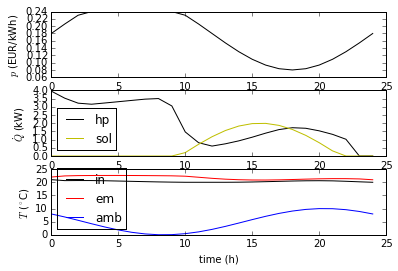

In [15]:
fig,ax = plt.subplots(nrows=3,ncols=1)
ax[0].plot(time/3600,pre['p_el'],'k',label='p')
ax[0].set_ylabel('$p$ (EUR/kWh)')


ax[1].plot(time/3600,sol['Q_flow_hp']/1000.,'k',label='hp')
ax[1].plot(time/3600,pre['Q_flow_sol']/1000.,'y',label='sol')
ax[1].set_ylabel('$\dot{Q}$ (kW)')
ax[1].legend(loc='best')

ax[2].plot(time/3600,sol['T_in'],'k',label='in')
ax[2].plot(time/3600,sol['T_em'],'r',label='em')
ax[2].plot(time/3600,pre['T_amb'],'b',label='amb')
ax[2].set_ylabel('$T$ ($^\circ$C)')
ax[2].set_xlabel('time (h)')
ax[2].legend(loc='best')